# Previsão de Fluxo de Tráfego

Dataset: https://archive.ics.uci.edu/dataset/734/traffic+flow+forecasting-1

O objetivo desse conjunto de dados é prever o volume de tráfego espaço-temporal com base no volume de tráfego histórico e outras características em locais vizinhos. Especificamente, <b>o volume de tráfego é medido a cada 15 minutos em 36 locais de sensores</b> ao longo de duas rodovias principais na região norte da Virgínia/Washington D.C. A região da capital dos Estados Unidos.

As 47 características incluem: 
- 1) a sequência histórica do volume de tráfego detectado nos 10 pontos de amostragem mais recentes (10 características),
- 2) dia da semana (7 características), 
- 3) hora do dia (24 características), 
- 4) direção da estrada (4 características), 
- 5) número de faixas (1 característica) e 
- 6) nome da estrada (1 característica).

O objetivo é prever o volume de tráfego 15 minutos no futuro para todos os locais de sensores. Com uma rede viária fornecida, conhecemos a conectividade espacial entre os locais de sensores.

<img src="Imagem/1.webp" style="width:600px;height:400px">

In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Carregando os dados

In [2]:
mat = scipy.io.loadmat('traffic+flow+forecasting/traffic_dataset.mat')

## Lendo e armazenando um array numpy em uma lista do Python

In [3]:
tra_X_tr_list=[mat['tra_X_tr'][0][i].toarray() for  i in range(len(mat['tra_X_tr'][0]))]
tra_X_te_list=[mat['tra_X_te'][0][i].toarray() for  i in range(len(mat['tra_X_te'][0]))]
tra_Y_tr_list=[mat['tra_Y_tr'][i] for  i in range(len(mat['tra_Y_tr']))]
tra_Y_te_list=[mat['tra_Y_te'][i] for  i in range(len(mat['tra_Y_te']))]
tra_adj_mat_list=[mat['tra_adj_mat'][i] for  i in range(len(mat['tra_adj_mat']))]

## Criando um dicionário para calcular o número de conexões para uma localização espacial

In [4]:
dict={}
for i in range(len(tra_adj_mat_list)):
    dict[i+1]=list(tra_adj_mat_list[i]).count(1)

def dict_apply(text):
    return dict[text]

### Criando um Data Frame de treinamento e o alvo (próximo fluxo de tráfego) para cada registro, obtendo o fluxo de tráfego para os próximos 15 minutos

In [5]:
out_train=list(zip([(i+1,j+1,tra_X_tr_list[i][j],tra_Y_tr_list[j][i]) for i in range(len(tra_Y_tr_list[0])) 
              for j in range(len(tra_Y_tr_list))]))
df_train=pd.DataFrame([x[0] for x in out_train],columns=['quarto_hora', 'num_local','input_array','fluxo_trafego'])
df_train['prox_fluxo_trafego'] = df_train.groupby("num_local")['fluxo_trafego'].shift(-1)
df_train['num_conexao']=df_train['num_local'].apply(dict_apply)
df_train[[f'caracteristica {i}' for i in range(0, 48)]]=pd.DataFrame(df_train["input_array"].tolist(), index= df_train.index)
df_train = df_train.drop(['input_array'], axis=1)
df_train = df_train.dropna()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45360 entries, 0 to 45359
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   quarto_hora         45360 non-null  int64  
 1   num_local           45360 non-null  int64  
 2   fluxo_trafego       45360 non-null  float64
 3   prox_fluxo_trafego  45360 non-null  float64
 4   num_conexao         45360 non-null  int64  
 5   caracteristica 0    45360 non-null  float64
 6   caracteristica 1    45360 non-null  float64
 7   caracteristica 2    45360 non-null  float64
 8   caracteristica 3    45360 non-null  float64
 9   caracteristica 4    45360 non-null  float64
 10  caracteristica 5    45360 non-null  float64
 11  caracteristica 6    45360 non-null  float64
 12  caracteristica 7    45360 non-null  float64
 13  caracteristica 8    45360 non-null  float64
 14  caracteristica 9    45360 non-null  float64
 15  caracteristica 10   45360 non-null  float64
 16  cara

In [7]:
df_train.shape

(45360, 53)

In [8]:
df_train.columns

Index(['quarto_hora', 'num_local', 'fluxo_trafego', 'prox_fluxo_trafego',
       'num_conexao', 'caracteristica 0', 'caracteristica 1',
       'caracteristica 2', 'caracteristica 3', 'caracteristica 4',
       'caracteristica 5', 'caracteristica 6', 'caracteristica 7',
       'caracteristica 8', 'caracteristica 9', 'caracteristica 10',
       'caracteristica 11', 'caracteristica 12', 'caracteristica 13',
       'caracteristica 14', 'caracteristica 15', 'caracteristica 16',
       'caracteristica 17', 'caracteristica 18', 'caracteristica 19',
       'caracteristica 20', 'caracteristica 21', 'caracteristica 22',
       'caracteristica 23', 'caracteristica 24', 'caracteristica 25',
       'caracteristica 26', 'caracteristica 27', 'caracteristica 28',
       'caracteristica 29', 'caracteristica 30', 'caracteristica 31',
       'caracteristica 32', 'caracteristica 33', 'caracteristica 34',
       'caracteristica 35', 'caracteristica 36', 'caracteristica 37',
       'caracteristica 38', 'car

In [9]:
#Agrupando os valores e identificar se há algum valor discrepante
df_train.groupby(['fluxo_trafego']).size()

fluxo_trafego
0.000000     4
0.000467     4
0.000934     6
0.001401    10
0.001868    11
            ..
0.961233     1
0.964035     1
0.976646     1
0.980850     1
1.000000     1
Length: 1902, dtype: int64

In [10]:
df_train.head()

quarto_hora  num_local  fluxo_trafego  prox_fluxo_trafego  num_conexao  \
0            1          1       0.050911            0.047641            4   
1            1          2       0.046240            0.049510            2   
2            1          3       0.050444            0.044372            2   
3            1          4       0.044839            0.038300            1   
4            1          5       0.044839            0.053246            5   

   caracteristica 0  caracteristica 1  caracteristica 2  caracteristica 3  \
0          0.092480          0.096684          0.070061          0.065857   
1          0.097151          0.102289          0.081738          0.076600   
2          0.115367          0.110696          0.105558          0.095283   
3          0.112097          0.102756          0.092013          0.083606   
4          0.127043          0.150864          0.131714          0.106025   

   caracteristica 4  ...  caracteristica 38  caracteristica 39  \
0          0.078468  ...                0.0                3.0   
1          0.072396  ...                0.0                4.0   
2          0.067725  ...                0.0                3.0   
3          0.062121  ...                0.0                3.0   
4          0.099019  ...                0.0                5.0   

   caracteristica 40  caracteristica 41  caracteristica 42  caracteristica 43  \
0                1.0                0.0                0.0                0.0   
1                1.0                0.0                0.0                0.0   
2                1.0                0.0                0.0                0.0   
3                1.0                0.0                0.0                0.0   
4                1.0                0.0                0.0                0.0   

   caracteristica 44  caracteristica 45  caracteristica 46  caracteristica 47  
0                1.0                0.0                0.0                0.0  
1                1.0                0.0                0.0                0.0  
2                1.0                0.0                0.0                0.0  
3                1.0                0.0                0.0                0.0  
4                0.0                1.0                0.0                0.0  

[5 rows x 53 columns]

In [11]:
# retirando alguns dados / criando dados ausentes 

for a in range(0,45360,120):
    df_train['fluxo_trafego'] = df_train['fluxo_trafego'].replace(df_train['fluxo_trafego'][a], np.nan)
for a in range(0,45360,5500):
    df_train['caracteristica 1'] = df_train['caracteristica 1'].replace(df_train['caracteristica 1'][a], np.nan)
for a in range(0,45360,10500):
    df_train['caracteristica 5'] = df_train['caracteristica 5'].replace(df_train['caracteristica 5'][a], np.nan)
for a in range(0,45360,8500):
    df_train['caracteristica 8'] = df_train['caracteristica 8'].replace(df_train['caracteristica 8'][a], np.nan)
for a in range(0,45360,10000):
    df_train['caracteristica 30'] = df_train['caracteristica 30'].replace(df_train['caracteristica 30'][a], np.nan)
for a in range(0,45360,15000):
    df_train['caracteristica 45'] = df_train['caracteristica 45'].replace(df_train['caracteristica 45'][a], np.nan)

In [12]:
df_train.head(100)

quarto_hora  num_local  fluxo_trafego  prox_fluxo_trafego  num_conexao  \
0             1          1            NaN            0.047641            4   
1             1          2       0.046240            0.049510            2   
2             1          3       0.050444            0.044372            2   
3             1          4       0.044839            0.038300            1   
4             1          5       0.044839            0.053246            5   
..          ...        ...            ...                 ...          ...   
95            3         24            NaN            0.025222            2   
96            3         25       0.012144            0.011677            2   
97            3         26            NaN            0.092480            7   
98            3         27       0.020084            0.025222            3   
99            3         28       0.020551            0.025222            1   

    caracteristica 0  caracteristica 1  caracteristica 2  caracteristica 3  \
0           0.092480               NaN          0.070061          0.065857   
1           0.097151          0.102289          0.081738          0.076600   
2           0.115367          0.110696          0.105558          0.095283   
3           0.112097          0.102756          0.092013          0.083606   
4           0.127043          0.150864          0.131714          0.106025   
..               ...               ...               ...               ...   
95          0.040168          0.044372          0.035497          0.033629   
96          0.023354          0.021018          0.015880          0.014479   
97          0.123307          0.133115          0.131714          0.107426   
98          0.062121          0.040168          0.044372          0.042036   
99          0.035965          0.033162          0.027090          0.027557   

    caracteristica 4  ...  caracteristica 38  caracteristica 39  \
0           0.078468  ...                0.0                3.0   
1           0.072396  ...                0.0                4.0   
2           0.067725  ...                0.0                3.0   
3           0.062121  ...                0.0                3.0   
4           0.099019  ...                0.0                5.0   
..               ...  ...                ...                ...   
95          0.035965  ...                0.0                2.0   
96          0.014946  ...                0.0                1.0   
97          0.092013  ...                0.0                4.0   
98          0.033162  ...                0.0                2.0   
99          0.025689  ...                0.0                5.0   

    caracteristica 40  caracteristica 41  caracteristica 42  \
0                 1.0                0.0                0.0   
1                 1.0                0.0                0.0   
2                 1.0                0.0                0.0   
3                 1.0                0.0                0.0   
4                 1.0                0.0                0.0   
..                ...                ...                ...   
95                0.0                0.0                1.0   
96                0.0                0.0                1.0   
97                0.0                0.0                1.0   
98                0.0                0.0                0.0   
99                0.0                0.0                0.0   

    caracteristica 43  caracteristica 44  caracteristica 45  \
0                 0.0                1.0                NaN   
1                 0.0                1.0                NaN   
2                 0.0                1.0                NaN   
3                 0.0                1.0                NaN   
4                 0.0                0.0                1.0   
..                ...                ...                ...   
95                0.0                1.0                NaN   
96                0.0                1.0                NaN   
9

In [13]:
# quantidade de numeros ausentes
df_train.isnull().sum()

quarto_hora               0
num_local                 0
fluxo_trafego         10991
prox_fluxo_trafego        0
num_conexao               0
caracteristica 0          0
caracteristica 1        343
caracteristica 2          0
caracteristica 3          0
caracteristica 4          0
caracteristica 5        223
caracteristica 6          0
caracteristica 7          0
caracteristica 8        246
caracteristica 9          0
caracteristica 10         0
caracteristica 11         0
caracteristica 12         0
caracteristica 13         0
caracteristica 14         0
caracteristica 15         0
caracteristica 16         0
caracteristica 17         0
caracteristica 18         0
caracteristica 19         0
caracteristica 20         0
caracteristica 21         0
caracteristica 22         0
caracteristica 23         0
caracteristica 24         0
caracteristica 25         0
caracteristica 26         0
caracteristica 27         0
caracteristica 28         0
caracteristica 29         0
caracteristica 30   

In [14]:
#percentagem de dados ausentes 
Percentual_dados_ausentes = (df_train.isnull().sum() / len(df_train['quarto_hora']))*100

In [15]:
Percentual_dados_ausentes

quarto_hora            0.000000
num_local              0.000000
fluxo_trafego         24.230600
prox_fluxo_trafego     0.000000
num_conexao            0.000000
caracteristica 0       0.000000
caracteristica 1       0.756173
caracteristica 2       0.000000
caracteristica 3       0.000000
caracteristica 4       0.000000
caracteristica 5       0.491623
caracteristica 6       0.000000
caracteristica 7       0.000000
caracteristica 8       0.542328
caracteristica 9       0.000000
caracteristica 10      0.000000
caracteristica 11      0.000000
caracteristica 12      0.000000
caracteristica 13      0.000000
caracteristica 14      0.000000
caracteristica 15      0.000000
caracteristica 16      0.000000
caracteristica 17      0.000000
caracteristica 18      0.000000
caracteristica 19      0.000000
caracteristica 20      0.000000
caracteristica 21      0.000000
caracteristica 22      0.000000
caracteristica 23      0.000000
caracteristica 24      0.000000
caracteristica 25      0.000000
caracter

In [18]:
# Preenchendo dados ausentes com a média

df_train['fluxo_trafego'].fillna(df_train['fluxo_trafego'].mean(), inplace=True)
df_train['caracteristica 1'].fillna(df_train['caracteristica 1'].mean(), inplace=True)
df_train['caracteristica 5'].fillna(df_train['caracteristica 5'].mean(), inplace=True)
df_train['caracteristica 8'].fillna(df_train['caracteristica 8'].mean(), inplace=True)
df_train['caracteristica 30'].fillna(df_train['caracteristica 30'].mean(), inplace=True)
df_train['caracteristica 45'].fillna(df_train['caracteristica 45'].mean(), inplace=True)

In [19]:
df_train.head(120)

quarto_hora  num_local  fluxo_trafego  prox_fluxo_trafego  num_conexao  \
0              1          1       0.332258            0.047641            4   
1              1          2       0.046240            0.049510            2   
2              1          3       0.050444            0.044372            2   
3              1          4       0.044839            0.038300            1   
4              1          5       0.044839            0.053246            5   
..           ...        ...            ...                 ...          ...   
115            4          8       0.035497            0.042036            1   
116            4          9       0.124241            0.125175            2   
117            4         10       0.140589            0.134517            2   
118            4         11       0.332258            0.100887            2   
119            4         12       0.127511            0.134984            1   

     caracteristica 0  caracteristica 1  caracteristica 2  caracteristica 3  \
0            0.092480          0.304299          0.070061          0.065857   
1            0.097151          0.102289          0.081738          0.076600   
2            0.115367          0.110696          0.105558          0.095283   
3            0.112097          0.102756          0.092013          0.083606   
4            0.127043          0.150864          0.131714          0.106025   
..                ...               ...               ...               ...   
115          0.070995          0.063989          0.047641          0.053713   
116          0.121906          0.126576          0.114433          0.102756   
117          0.159271          0.145726          0.137319          0.134517   
118          0.141523          0.127511          0.120504          0.085007   
119          0.155068          0.140121          0.104157          0.119103   

     caracteristica 4  ...  caracteristica 38  caracteristica 39  \
0            0.078468  ...                0.0                3.0   
1            0.072396  ...                0.0                4.0   
2            0.067725  ...                0.0                3.0   
3            0.062121  ...                0.0                3.0   
4            0.099019  ...                0.0                5.0   
..                ...  ...                ...                ...   
115          0.040635  ...                0.0                4.0   
116          0.109295  ...                0.0                4.0   
117          0.141523  ...                0.0                4.0   
118          0.107894  ...                0.0                4.0   
119          0.113965  ...                0.0                3.0   

     caracteristica 40  caracteristica 41  caracteristica 42  \
0                  1.0                0.0                0.0   
1                  1.0                0.0                0.0   
2                  1.0                0.0                0.0   
3                  1.0                0.0                0.0   
4                  1.0                0.0                0.0   
..                 ...                ...                ...   
115                1.0                0.0                0.0   
116                0.0                1.0                0.0   
117                0.0                1.0                0.0   
118                0.0                1.0                0.0   
119                0.0                1.0                0.0   

     caracteristica 43  caracteristica 44  caracteristica 45  \
0                  0.0                1.0                1.0   
1                  0.0                1.0                1.0   
2                  0.0                1.0                1.0   
3                  0.0                1.0                1.0   
4                  0.0                0.0                1.0   
..                 ...                ...                ...   
115                0.0                0.0                1.0   
116      

In [20]:
df_train.describe().T

count        mean         std  min         25%  \
quarto_hora         45360.0  630.500000  363.734564  1.0  315.750000   
num_local           45360.0   18.500000   10.388409  1.0    9.750000   
fluxo_trafego       45360.0    0.332258    0.175333  0.0    0.219524   
prox_fluxo_trafego  45360.0    0.304464    0.199538  0.0    0.127043   
num_conexao         45360.0    2.388889    1.318216  1.0    2.000000   
caracteristica 0    45360.0    0.303488    0.199528  0.0    0.125642   
caracteristica 1    45360.0    0.304299    0.198830  0.0    0.127043   
caracteristica 2    45360.0    0.303383    0.199627  0.0    0.125175   
caracteristica 3    45360.0    0.303356    0.199653  0.0    0.124708   
caracteristica 4    45360.0    0.303347    0.199664  0.0    0.124708   
caracteristica 5    45360.0    0.304535    0.198942  0.0    0.127978   
caracteristica 6    45360.0    0.303396    0.199635  0.0    0.124708   
caracteristica 7    45360.0    0.303476    0.199592  0.0    0.125175   
caracteristica 8    45360.0    0.303761    0.199172  0.0    0.126576   
caracteristica 9    45360.0    0.303751    0.199524  0.0    0.125642   
caracteristica 10   45360.0    0.228571    0.419917  0.0    0.000000   
caracteristica 11   45360.0    0.228571    0.419917  0.0    0.000000   
caracteristica 12   45360.0    0.228571    0.419917  0.0    0.000000   
caracteristica 13   45360.0    0.161905    0.368367  0.0    0.000000   
caracteristica 14   45360.0    0.152381    0.359394  0.0    0.000000   
caracteristica 15   45360.0    0.044444    0.206083  0.0    0.000000   
caracteristica 16   45360.0    0.044444    0.206083  0.0    0.000000   
caracteristica 17   45360.0    0.044444    0.206083  0.0    0.000000   
caracteristica 18   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 19   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 20   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 21   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 22   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 23   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 24   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 25   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 26   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 27   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 28   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 29   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 30   45360.0    1.000000    0.000000  1.0    1.000000   
caracteristica 31   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 32   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 33   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 34   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 35   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 36   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 37   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 38   45360.0    0.041270    0.198916  0.0    0.000000   
caracteristica 39   45360.0    3.527778    0.832879  1.0    3.000000   
caracteristica 40   45360.0    0.222222    0.415744  0.0    0.000000   
caracteristica 41   45360.0    0.388889    0.487503  0.0    0.000000   
caracteristica 42   45360.0    0.111111    0.314273  0.0    0.000000   
caracteristica 43   45360.0    0.277778    0.447908  0.0    0.000000   
caracteristica 44   45360.0    0.416667    0.493012  0.0    0.000000   
caracteristica 45   45360.0    1.000000    0.000000  1.0    1.000000   
caracteristica 46   45360.0    0.138889    0.345834  0.0    0.000000   
caracteristica 47   45360.0    0.138889    0.345834  0.0    0.000000   

                           50%         75%     max  
quarto_hora         630.500000  945.250000  1260.0  
num_local            18.500

In [21]:
#quantidade de numeros ausentes
df_train.isnull().sum()

quarto_hora           0
num_local             0
fluxo_trafego         0
prox_fluxo_trafego    0
num_conexao           0
caracteristica 0      0
caracteristica 1      0
caracteristica 2      0
caracteristica 3      0
caracteristica 4      0
caracteristica 5      0
caracteristica 6      0
caracteristica 7      0
caracteristica 8      0
caracteristica 9      0
caracteristica 10     0
caracteristica 11     0
caracteristica 12     0
caracteristica 13     0
caracteristica 14     0
caracteristica 15     0
caracteristica 16     0
caracteristica 17     0
caracteristica 18     0
caracteristica 19     0
caracteristica 20     0
caracteristica 21     0
caracteristica 22     0
caracteristica 23     0
caracteristica 24     0
caracteristica 25     0
caracteristica 26     0
caracteristica 27     0
caracteristica 28     0
caracteristica 29     0
caracteristica 30     0
caracteristica 31     0
caracteristica 32     0
caracteristica 33     0
caracteristica 34     0
caracteristica 35     0
caracteristica 3

In [22]:
#Contar o número de elementos distintos
df_train.nunique()

quarto_hora           1260
num_local               36
fluxo_trafego         1587
prox_fluxo_trafego    1902
num_conexao              6
caracteristica 0      1901
caracteristica 1      1893
caracteristica 2      1901
caracteristica 3      1901
caracteristica 4      1901
caracteristica 5      1897
caracteristica 6      1901
caracteristica 7      1901
caracteristica 8      1896
caracteristica 9      1901
caracteristica 10        2
caracteristica 11        2
caracteristica 12        2
caracteristica 13        2
caracteristica 14        2
caracteristica 15        2
caracteristica 16        2
caracteristica 17        2
caracteristica 18        2
caracteristica 19        2
caracteristica 20        2
caracteristica 21        2
caracteristica 22        2
caracteristica 23        2
caracteristica 24        2
caracteristica 25        2
caracteristica 26        2
caracteristica 27        2
caracteristica 28        2
caracteristica 29        2
caracteristica 30        1
caracteristica 31        2
c

In [23]:
caracteristicas_numericas=[f'caracteristica {i}' for i in range(0, 10)]
caracteristicas_categoricas=[f'caracteristica {i}' for i in range(10, 48)]+['num_conexao']

In [24]:
df_train.head()

quarto_hora  num_local  fluxo_trafego  prox_fluxo_trafego  num_conexao  \
0            1          1       0.332258            0.047641            4   
1            1          2       0.046240            0.049510            2   
2            1          3       0.050444            0.044372            2   
3            1          4       0.044839            0.038300            1   
4            1          5       0.044839            0.053246            5   

   caracteristica 0  caracteristica 1  caracteristica 2  caracteristica 3  \
0          0.092480          0.304299          0.070061          0.065857   
1          0.097151          0.102289          0.081738          0.076600   
2          0.115367          0.110696          0.105558          0.095283   
3          0.112097          0.102756          0.092013          0.083606   
4          0.127043          0.150864          0.131714          0.106025   

   caracteristica 4  ...  caracteristica 38  caracteristica 39  \
0          0.078468  ...                0.0                3.0   
1          0.072396  ...                0.0                4.0   
2          0.067725  ...                0.0                3.0   
3          0.062121  ...                0.0                3.0   
4          0.099019  ...                0.0                5.0   

   caracteristica 40  caracteristica 41  caracteristica 42  caracteristica 43  \
0                1.0                0.0                0.0                0.0   
1                1.0                0.0                0.0                0.0   
2                1.0                0.0                0.0                0.0   
3                1.0                0.0                0.0                0.0   
4                1.0                0.0                0.0                0.0   

   caracteristica 44  caracteristica 45  caracteristica 46  caracteristica 47  
0                1.0                1.0                0.0                0.0  
1                1.0                1.0                0.0                0.0  
2                1.0                1.0                0.0                0.0  
3                1.0                1.0                0.0                0.0  
4                0.0                1.0                0.0                0.0  

[5 rows x 53 columns]

# Perguntas

### 1-	Qual é a Média de Fluxo de Tráfego por Localidade?

In [26]:
Media = df_train.groupby("num_local").mean()

In [27]:
Media["fluxo_trafego"]

num_local
1     0.288283
2     0.353646
3     0.251905
4     0.276783
5     0.351940
6     0.336212
7     0.366204
8     0.293328
9     0.379581
10    0.447969
11    0.396115
12    0.345509
13    0.398687
14    0.397504
15    0.510789
16    0.242017
17    0.298567
18    0.316779
19    0.327146
20    0.401913
21    0.385779
22    0.417339
23    0.231629
24    0.217718
25    0.202073
26    0.483354
27    0.284164
28    0.222849
29    0.208560
30    0.370377
31    0.379470
32    0.370019
33    0.182200
34    0.273954
35    0.379233
36    0.371681
Name: fluxo_trafego, dtype: float64

In [28]:
x = Media["fluxo_trafego"].index
x

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36],
           dtype='int64', name='num_local')

In [29]:
y = Media["fluxo_trafego"].values
y

array([0.28828303, 0.3536459 , 0.2519052 , 0.27678282, 0.35194018,
       0.33621176, 0.36620429, 0.2933277 , 0.37958097, 0.44796949,
       0.39611496, 0.34550935, 0.39868743, 0.39750397, 0.51078919,
       0.24201707, 0.29856746, 0.31677886, 0.32714637, 0.40191338,
       0.38577876, 0.41733881, 0.23162894, 0.21771762, 0.20207326,
       0.4833538 , 0.28416407, 0.22284928, 0.20856009, 0.37037652,
       0.37946989, 0.37001877, 0.18219997, 0.27395441, 0.37923292,
       0.37168062])

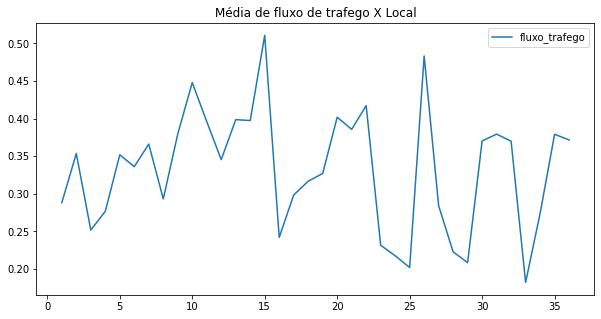

In [30]:
plt.figure(figsize=(10,5))
plt.plot(x,y, label="fluxo_trafego")
plt.legend()
plt.title("Média de fluxo de trafego X Local")
plt.show()

### 2-	Qual é a Relação entre a Característica 0 e o Próximo Fluxo de Tráfego?

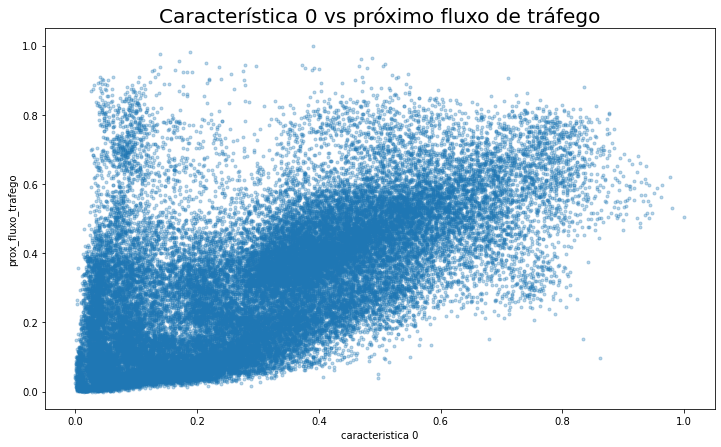

In [31]:
plt.figure(figsize=(12,7))
plt.xlabel('caracteristica 0')
plt.ylabel('prox_fluxo_trafego')
plt.title('Característica 0 vs próximo fluxo de tráfego', fontsize=20)
plt.plot(df_train['caracteristica 0'], df_train.prox_fluxo_trafego, ".",alpha = 0.3)

### 3-	Qual é o Impacto do número de conexões para o Alvo (próximo fluxo de tráfego)?

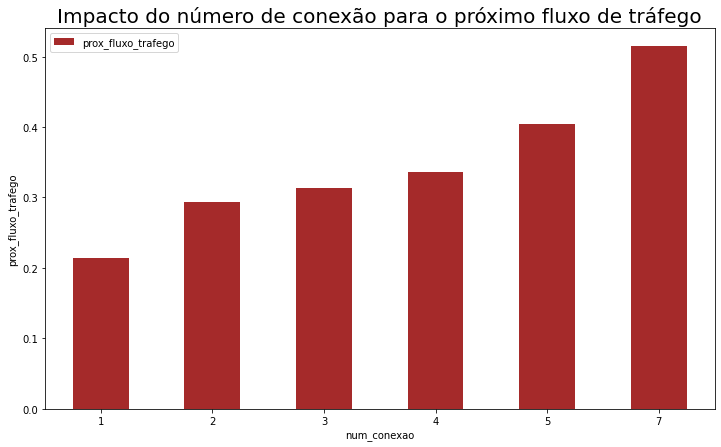

In [32]:
Item_Type_pivot = \
df_train.pivot_table(index='num_conexao', values="prox_fluxo_trafego", aggfunc=np.median)

Item_Type_pivot.plot(kind='bar',color='brown',figsize=(12,7))
plt.xlabel('num_conexao')
plt.ylabel("prox_fluxo_trafego")
plt.title("Impacto do número de conexão para o próximo fluxo de tráfego", fontsize=20)
plt.xticks(rotation=0)
plt.show()

### 4-	Qual é a Relação entre Característica 10 e o Próximo Fluxo de Tráfego?

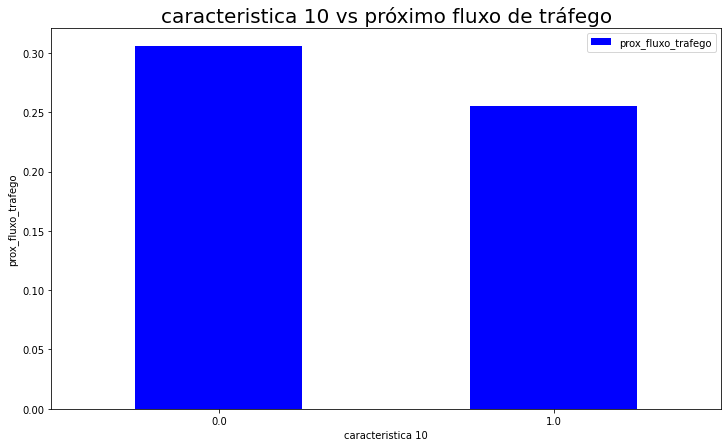

In [33]:
Item_Type_pivot = \
df_train.pivot_table(index='caracteristica 10', values="prox_fluxo_trafego", aggfunc=np.median)

Item_Type_pivot.plot(kind='bar',color='blue',figsize=(12,7))
plt.xlabel('caracteristica 10')
plt.ylabel("prox_fluxo_trafego")
plt.title("caracteristica 10 vs próximo fluxo de tráfego",fontsize=20)
plt.xticks(rotation=0)
plt.show()


### 5-	Qual é a correlação em características numéricas?

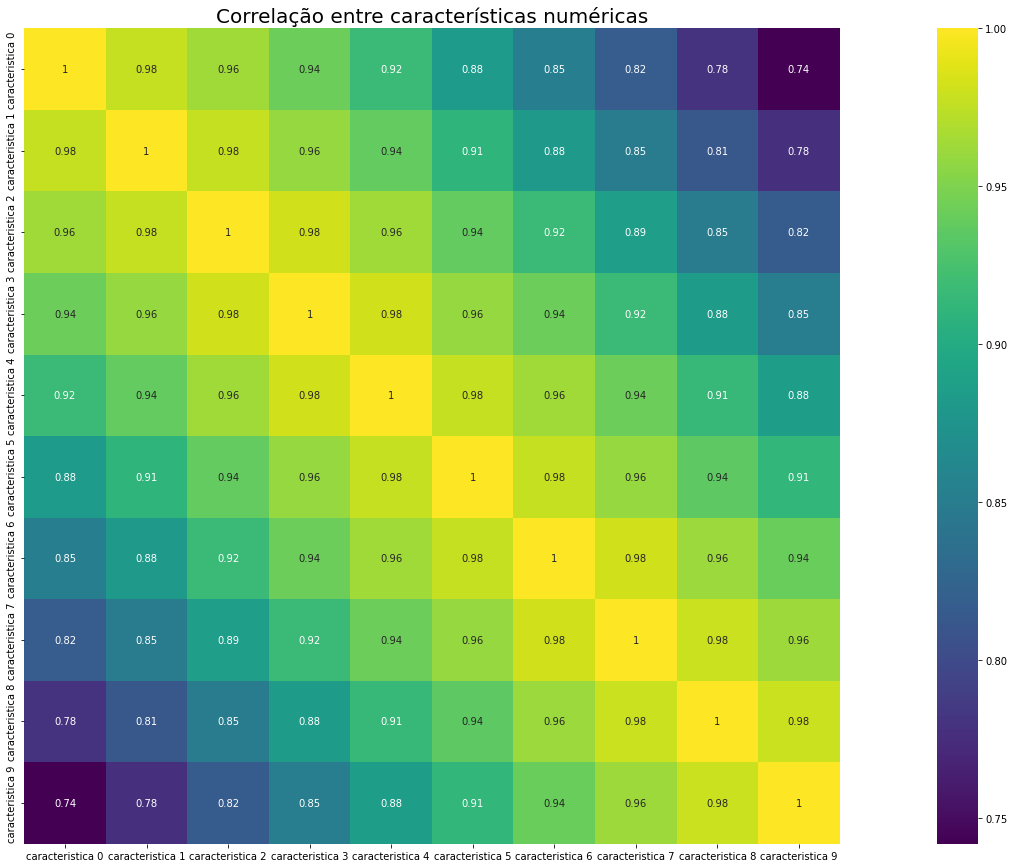

In [34]:
plt.figure(figsize=(35,15))
sns.heatmap(df_train[caracteristicas_numericas].corr(),vmax=1, square=True,annot=True, cmap='viridis')
plt.title('Correlação entre características numéricas', fontsize=20)
plt.show()